In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
import nibabel as nib
import os
import torch
import torch.nn as nn
import tqdm
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from scipy import ndimage
from skimage.measure import label

In [3]:
#Load Dataset 2 
adc_images = []
dwi_images = []
masks = []
adc_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/img/adc"
dwi_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/img/dwi"
mask_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_2/mask"

for filename in os.listdir(adc_dir):
    if filename.endswith(".gz"):
        adc_path = os.path.join(adc_dir, filename)
        adc_img = nib.load(adc_path).get_fdata()
        adc_images.append(adc_img)
for filename in os.listdir(dwi_dir):
    if filename.endswith(".gz"):
        dwi_path = os.path.join(dwi_dir, filename)
        dwi_img = nib.load(dwi_path).get_fdata()
        dwi_images.append(dwi_img)
for filename in os.listdir(mask_dir):
    if filename.endswith(".gz"):
        mask_path = os.path.join(mask_dir, filename)
        mask_img = nib.load(mask_path).get_fdata()
        masks.append(mask_img)

In [4]:
#Load Dataset 3
ds3_test_adc = []
ds3_train_adc = []
ds3_test_dwi = []
ds3_train_dwi = []
ds3_test_masks = []
ds3_train_masks = []
ds3_test_dir_adc = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_3/test/img/adc"
ds3_test_dir_dwi = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_3/test/img/dwi"
ds3_train_dir_adc = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_3/train/img/adc"
ds3_train_dir_dwi = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_3/train/img/dwi"
ds3_test_mask_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_3/test/mask"
ds3_train_mask_dir = r"/home/pritamk/AIMIA/DS-261-AIMIA/AIMIA_Assignment_2/dataset_3/train/mask"
for filename in os.listdir(ds3_test_dir_adc):
    if filename.endswith(".gz"):
        adc_path = os.path.join(ds3_test_dir_adc, filename)
        adc_img = nib.load(adc_path).get_fdata()
        ds3_test_adc.append(adc_img)
for filename in os.listdir(ds3_train_dir_adc):
    if filename.endswith(".gz"):
        adc_path = os.path.join(ds3_train_dir_adc, filename)
        adc_img = nib.load(adc_path).get_fdata()
        ds3_train_adc.append(adc_img)
for filename in os.listdir(ds3_test_dir_dwi):
    if filename.endswith(".gz"):
        dwi_path = os.path.join(ds3_test_dir_dwi, filename)
        dwi_img = nib.load(dwi_path).get_fdata()
        ds3_test_dwi.append(dwi_img)
for filename in os.listdir(ds3_train_dir_dwi):
    if filename.endswith(".gz"):
        dwi_path = os.path.join(ds3_train_dir_dwi, filename)
        dwi_img = nib.load(dwi_path).get_fdata()
        ds3_train_dwi.append(dwi_img)
for filename in os.listdir(ds3_test_mask_dir):
    if filename.endswith(".gz"):
        mask_path = os.path.join(ds3_test_mask_dir, filename)
        mask_img = nib.load(mask_path).get_fdata()
        ds3_test_masks.append(mask_img)
for filename in os.listdir(ds3_train_mask_dir):
    if filename.endswith(".gz"):
        mask_path = os.path.join(ds3_train_mask_dir, filename)
        mask_img = nib.load(mask_path).get_fdata()
        ds3_train_masks.append(mask_img)

print(f"Shape of ADC images from Dataset 3: {np.array(ds3_train_adc).shape}")
print(f"Shape of DWI images from Dataset 3: {np.array(ds3_train_dwi).shape}")
print(f"Shape of Mask images from Dataset 3: {np.array(ds3_train_masks).shape}")
print(f"Shape of ADC images for testing from Dataset 3: {np.array(ds3_test_adc).shape}")
print(f"Shape of DWI images for testing from Dataset 3: {np.array(ds3_test_dwi).shape}")
print(f"Shape of Mask images for testing from Dataset 3: {np.array(ds3_test_masks).shape}")

Shape of ADC images from Dataset 3: (950, 64, 64)
Shape of DWI images from Dataset 3: (950, 64, 64)
Shape of Mask images from Dataset 3: (950, 64, 64)
Shape of ADC images for testing from Dataset 3: (407, 64, 64)
Shape of DWI images for testing from Dataset 3: (407, 64, 64)
Shape of Mask images for testing from Dataset 3: (407, 64, 64)


In [5]:
adc_images[0].shape, dwi_images[0].shape, masks[0].shape

((64, 64), (64, 64), (64, 64))

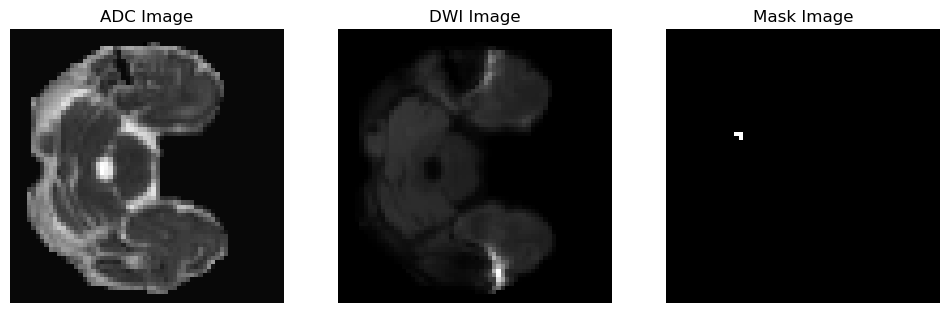

In [6]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(adc_images[0], cmap='gray')
plt.title('ADC Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(dwi_images[0], cmap='gray')
plt.title('DWI Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(masks[0], cmap='gray')
plt.title('Mask Image')
plt.axis('off')
plt.show()

In [7]:
adc_images = np.array(adc_images)
dwi_images = np.array(dwi_images)
masks = np.array(masks)
print(adc_images.shape, dwi_images.shape, masks.shape)

(1504, 64, 64) (1504, 64, 64) (1504, 64, 64)


In [8]:
X = np.stack((adc_images, dwi_images), axis=0) # Combine ADC and DWI images. There are two channels in the training images
y = masks[np.newaxis, ...] # Add a new axis to masks to match the shape of X
print(X.shape, y.shape)

(2, 1504, 64, 64) (1, 1504, 64, 64)


In [9]:
#Combine adc and dwi images from dataset 3
ds3_train_images = np.stack((ds3_train_adc, ds3_train_dwi), axis=0)
ds3_test_images = np.stack((ds3_test_adc, ds3_test_dwi), axis=0)
ds3_train_masks = np.array(ds3_train_masks)[np.newaxis, ...]
ds3_test_masks = np.array(ds3_test_masks)[np.newaxis, ...]
ds3_train_images[np.isnan(ds3_train_images)] = 0 # Replace NaN values with 0
ds3_test_images[np.isnan(ds3_test_images)] = 0
print(ds3_train_images.shape, ds3_train_masks.shape)
print(ds3_test_images.shape, ds3_test_masks.shape)


(2, 950, 64, 64) (1, 950, 64, 64)
(2, 407, 64, 64) (1, 407, 64, 64)


In [10]:
def normalize_data(X, y):
    X_norm = np.zeros_like(X)
    for i in range(X.shape[0]):  # For two channels
        X_norm[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min() + 1e-8)
    
    y_norm = (y > 0).astype(np.float32)
    
    return X_norm, y_norm

X_normalized, y_normalized = normalize_data(X, y)
print(f"Normalized X range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
print(f"Normalized y range: [{y_normalized.min():.3f}, {y_normalized.max():.3f}]")
print(f"Unique values in masks: {np.unique(y_normalized, return_counts=True)}")


X_tensor = torch.FloatTensor(X_normalized).permute(1, 0, 2, 3)  # (samples, channels, H, W)
y_tensor = torch.FloatTensor(y_normalized).permute(1, 0, 2, 3)  # (samples, classes, H, W)

print(f"X tensor shape: {X_tensor.shape}")
print(f"y tensor shape: {y_tensor.shape}")

Normalized X range: [0.000, 1.000]
Normalized y range: [0.000, 1.000]
Unique values in masks: (array([0., 1.], dtype=float32), array([6082668,   77716]))
X tensor shape: torch.Size([1504, 2, 64, 64])
y tensor shape: torch.Size([1504, 1, 64, 64])


In [11]:
#Normalize datasets 3
ds3_train_images_normalized, ds3_train_masks_normalized = normalize_data(ds3_train_images, ds3_train_masks)
ds3_test_images_normalized, ds3_test_masks_normalized = normalize_data(ds3_test_images, ds3_test_masks)
ds3_train = torch.FloatTensor(ds3_train_images_normalized).permute(1, 0, 2, 3) # Has NaN values
ds3_train_masks = torch.FloatTensor(ds3_train_masks_normalized).permute(1, 0, 2, 3)
ds3_test = torch.FloatTensor(ds3_test_images_normalized).permute(1, 0, 2, 3) #Has NaN values
ds3_test_masks = torch.FloatTensor(ds3_test_masks_normalized).permute(1, 0, 2, 3)
print(f"DS3 Train tensor shape: {ds3_train.shape}")
print(f"DS3 masks tensor shape: {ds3_train_masks.shape}")
print(f"DS3 Test tensor shape: {ds3_test.shape}")
print(f"DS3 Test masks tensor shape: {ds3_test_masks.shape}")

DS3 Train tensor shape: torch.Size([950, 2, 64, 64])
DS3 masks tensor shape: torch.Size([950, 1, 64, 64])
DS3 Test tensor shape: torch.Size([407, 2, 64, 64])
DS3 Test masks tensor shape: torch.Size([407, 1, 64, 64])


In [12]:
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=8, shuffle=True)
val_loader = DataLoader(TensorDataset(ds3_test, ds3_test_masks), batch_size=8, shuffle=False)
print(f"Train shape {X_tensor.shape}, labels shape {y_tensor.shape}")
print(f"Validation shape {ds3_test.shape}, labels shape {ds3_test_masks.shape}")
print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")

Train shape torch.Size([1504, 2, 64, 64]), labels shape torch.Size([1504, 1, 64, 64])
Validation shape torch.Size([407, 2, 64, 64]), labels shape torch.Size([407, 1, 64, 64])
Number of batches in train loader: 188
Number of batches in validation loader: 51


In [13]:
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred) # Element-wise multiplication and sum. If y_true and y_pred are binary masks, this gives the number of pixels that are predicted as positive and are actually positive.
    total = np.sum(y_true) + np.sum(y_pred) # total number of positive pixels in both masks
    if total == 0:
        return 1.0  
    return 2. * intersection / total

def lesion_wise_accuracy(y_true, y_pred):
    true_labeled, true_num_lesions = label(y_true, return_num=True)
    pred_labeled, pred_num_lesions = label(y_pred, return_num=True)
    
    if true_num_lesions == 0 and pred_num_lesions == 0:
        return 1.0  # Perfect if both have no lesions
    
    if true_num_lesions == 0 or pred_num_lesions == 0:
        return 0.0  # One has lesions, other does not
    
    # Count overlapping lesions
    true_positive = 0
    
    for true_lesion_id in range(1, true_num_lesions + 1):
        true_lesion_mask = (true_labeled == true_lesion_id)
        
        overlapping_pred_labels = np.unique(pred_labeled[true_lesion_mask]) # Check if any predicted lesion overlaps with this true lesion
        overlapping_pred_labels = overlapping_pred_labels[overlapping_pred_labels != 0]
        
        if len(overlapping_pred_labels) > 0:
             
            for pred_label in overlapping_pred_labels: # Check if the overlap is significant
                pred_lesion_mask = (pred_labeled == pred_label)
                intersection = np.sum(true_lesion_mask & pred_lesion_mask)
                true_lesion_size = np.sum(true_lesion_mask)
                
                if intersection / true_lesion_size > 0.5:  
                    true_positive += 1
                    break
    
    # Calculate metrics
    false_negative = true_num_lesions - true_positive
    false_positive = pred_num_lesions - true_positive
    
    if true_positive + false_negative == 0:
        sensitivity = 1.0
    else:
        sensitivity = true_positive / (true_positive + false_negative)
    
    if true_positive + false_positive == 0:
        precision = 1.0
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if precision + sensitivity == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return f1


In [ ]:
def trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs, device, patience_counter, scheduler=None):
    training_losses = []
    validation_losses = []
    best_val_loss = float('inf')
    train_dice_scores = []
    valid_dice_scores = []
    patience = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_dice_total = 0.0
        num_train_batches = 0
        
        for batch_idx, (images, masks) in enumerate(tqdm.tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}")):
            images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            
            outputs = model(images)  # logits 
            loss = criterion(outputs, masks)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            with torch.no_grad():
                preds = (torch.sigmoid(outputs) > 0.5).float()
                batch_dice = dice_score(masks.cpu().numpy(), preds.cpu().numpy())
                train_dice_total += batch_dice
            
            train_loss += loss.item() * images.size(0)
            num_train_batches += 1
        
        epoch_train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(epoch_train_loss)
        epoch_dice_score = train_dice_total / num_train_batches
        train_dice_scores.append(epoch_dice_score)
        
        # Validation
        model.eval()
        validation_loss = 0.0
        val_dice_total = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for images, masks in tqdm.tqdm(test_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images, masks = images.to(device, dtype=torch.float32), masks.to(device, dtype=torch.float32)
                outputs = model(images)
                loss = criterion(outputs, masks)
                validation_loss += loss.item() * images.size(0)
                
                preds = (torch.sigmoid(outputs) > 0.5).float()
                batch_dice = dice_score(masks.cpu().numpy(), preds.cpu().numpy())
                val_dice_total += batch_dice
                num_val_batches += 1
        
        epoch_val_loss = validation_loss / len(test_loader.dataset)
        validation_losses.append(epoch_val_loss)
        epoch_dice_score_val = val_dice_total / num_val_batches
        valid_dice_scores.append(epoch_dice_score_val)
        
        print("*"*50)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Train Dice Score: {epoch_dice_score:.4f}, Val Dice Score: {epoch_dice_score_val:.4f}")
        print("*"*50)
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience = 0
        else:
            patience += 1
            if patience >= patience_counter:
                print("Early stopping triggered")
                break
                
        if scheduler:
            scheduler.step(epoch_val_loss)
    
    return training_losses, validation_losses, train_dice_scores, valid_dice_scores

In [15]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.3):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
    
    def dice_loss(self, pred, target, smooth=1):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
        return 1 - dice
    
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice_loss(pred, target)
        return bce_loss +  dice_loss

In [16]:
model1 = smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",in_channels=2,classes=1)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1.to(DEVICE)
parameters_count = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Number of trainable parameters in the model: {parameters_count}")

Number of trainable parameters in the model: 24433233


In [17]:
criterion = CombinedLoss(alpha=0.7)
optimizer = torch.optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

In [21]:
training_losses, validation_losses, train_dice_scores, valid_dice_scores = trainer_class(model1, train_loader, val_loader, criterion, optimizer, num_epochs=50, device=DEVICE, patience_counter=10, scheduler=scheduler)

Validation Epoch 1/50: 100%|██████████| 51/51 [00:00<00:00, 195.81it/s]


**************************************************
Epoch 1/50, Train Loss: 1.3760, Val Loss: 1.1872
Epoch 1/50, Train Dice Score: 0.1895, Val Dice Score: 0.0343
**************************************************


/home/pritamk/miniconda3/envs/AIMIA/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Validation Epoch 2/50: 100%|██████████| 51/51 [00:00<00:00, 194.62it/s]


**************************************************
Epoch 2/50, Train Loss: 1.0422, Val Loss: 1.1390
Epoch 2/50, Train Dice Score: 0.4221, Val Dice Score: 0.0616
**************************************************


Validation Epoch 3/50: 100%|██████████| 51/51 [00:00<00:00, 193.97it/s]


**************************************************
Epoch 3/50, Train Loss: 0.8848, Val Loss: 1.1343
Epoch 3/50, Train Dice Score: 0.4992, Val Dice Score: 0.0549
**************************************************


Validation Epoch 4/50: 100%|██████████| 51/51 [00:00<00:00, 196.45it/s]


**************************************************
Epoch 4/50, Train Loss: 0.7243, Val Loss: 1.0937
Epoch 4/50, Train Dice Score: 0.5727, Val Dice Score: 0.0764
**************************************************


Validation Epoch 5/50: 100%|██████████| 51/51 [00:00<00:00, 195.31it/s]


**************************************************
Epoch 5/50, Train Loss: 0.5992, Val Loss: 1.1095
Epoch 5/50, Train Dice Score: 0.6162, Val Dice Score: 0.0786
**************************************************


Validation Epoch 6/50: 100%|██████████| 51/51 [00:00<00:00, 196.77it/s]


**************************************************
Epoch 6/50, Train Loss: 0.4935, Val Loss: 1.0915
Epoch 6/50, Train Dice Score: 0.6609, Val Dice Score: 0.0958
**************************************************


Validation Epoch 7/50: 100%|██████████| 51/51 [00:00<00:00, 190.63it/s]


**************************************************
Epoch 7/50, Train Loss: 0.4170, Val Loss: 1.1000
Epoch 7/50, Train Dice Score: 0.6964, Val Dice Score: 0.0961
**************************************************


Validation Epoch 8/50: 100%|██████████| 51/51 [00:00<00:00, 195.43it/s]


**************************************************
Epoch 8/50, Train Loss: 0.3972, Val Loss: 1.1565
Epoch 8/50, Train Dice Score: 0.6945, Val Dice Score: 0.0731
**************************************************


Validation Epoch 9/50: 100%|██████████| 51/51 [00:00<00:00, 189.71it/s]


**************************************************
Epoch 9/50, Train Loss: 0.3376, Val Loss: 1.0544
Epoch 9/50, Train Dice Score: 0.7361, Val Dice Score: 0.1162
**************************************************


Validation Epoch 10/50: 100%|██████████| 51/51 [00:00<00:00, 194.29it/s]


**************************************************
Epoch 10/50, Train Loss: 0.3213, Val Loss: 1.1005
Epoch 10/50, Train Dice Score: 0.7400, Val Dice Score: 0.0895
**************************************************


Validation Epoch 11/50: 100%|██████████| 51/51 [00:00<00:00, 194.07it/s]


**************************************************
Epoch 11/50, Train Loss: 0.3139, Val Loss: 1.1023
Epoch 11/50, Train Dice Score: 0.7427, Val Dice Score: 0.1047
**************************************************


Validation Epoch 12/50: 100%|██████████| 51/51 [00:00<00:00, 178.62it/s]


**************************************************
Epoch 12/50, Train Loss: 0.3026, Val Loss: 1.1324
Epoch 12/50, Train Dice Score: 0.7474, Val Dice Score: 0.0981
**************************************************


Validation Epoch 13/50: 100%|██████████| 51/51 [00:00<00:00, 192.79it/s]


**************************************************
Epoch 13/50, Train Loss: 0.2815, Val Loss: 1.1298
Epoch 13/50, Train Dice Score: 0.7635, Val Dice Score: 0.1017
**************************************************


Validation Epoch 14/50: 100%|██████████| 51/51 [00:00<00:00, 195.15it/s]


**************************************************
Epoch 14/50, Train Loss: 0.2649, Val Loss: 1.0732
Epoch 14/50, Train Dice Score: 0.7771, Val Dice Score: 0.1142
**************************************************


Validation Epoch 15/50: 100%|██████████| 51/51 [00:00<00:00, 195.32it/s]


**************************************************
Epoch 15/50, Train Loss: 0.2424, Val Loss: 1.1579
Epoch 15/50, Train Dice Score: 0.7962, Val Dice Score: 0.0950
**************************************************


Validation Epoch 16/50: 100%|██████████| 51/51 [00:00<00:00, 192.27it/s]


**************************************************
Epoch 16/50, Train Loss: 0.2248, Val Loss: 1.1311
Epoch 16/50, Train Dice Score: 0.8103, Val Dice Score: 0.0970
**************************************************


Validation Epoch 17/50: 100%|██████████| 51/51 [00:00<00:00, 195.67it/s]


**************************************************
Epoch 17/50, Train Loss: 0.2169, Val Loss: 1.0803
Epoch 17/50, Train Dice Score: 0.8170, Val Dice Score: 0.1078
**************************************************


Validation Epoch 18/50: 100%|██████████| 51/51 [00:00<00:00, 129.72it/s]


**************************************************
Epoch 18/50, Train Loss: 0.2084, Val Loss: 1.1299
Epoch 18/50, Train Dice Score: 0.8242, Val Dice Score: 0.0939
**************************************************


Validation Epoch 19/50: 100%|██████████| 51/51 [00:00<00:00, 194.23it/s]

**************************************************
Epoch 19/50, Train Loss: 0.2095, Val Loss: 1.1361
Epoch 19/50, Train Dice Score: 0.8216, Val Dice Score: 0.1096
**************************************************
Early stopping triggered


In [18]:
class plotGraphs:
    def __init__(self, title):
        self.title = title

    def plot_losses(self, training_losses, validation_losses):    
        plt.figure(figsize=(8, 5))
        plt.plot(training_losses, label='Training Loss', color='blue', marker ='o')
        plt.plot(validation_losses, label='Validation Loss', color='orange', marker ='s')
        plt.title(self.title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()
    def plot_metrics(self, train_dice_scores, valid_dice_scores):    
        plt.figure(figsize=(8, 5))
        plt.plot(train_dice_scores, label='Training Dice Score', color='blue', marker ='o')
        plt.plot(valid_dice_scores, label='Validation Dice Score', color='red', marker ='s')
        plt.title(self.title)
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
        plt.grid()
        plt.show()


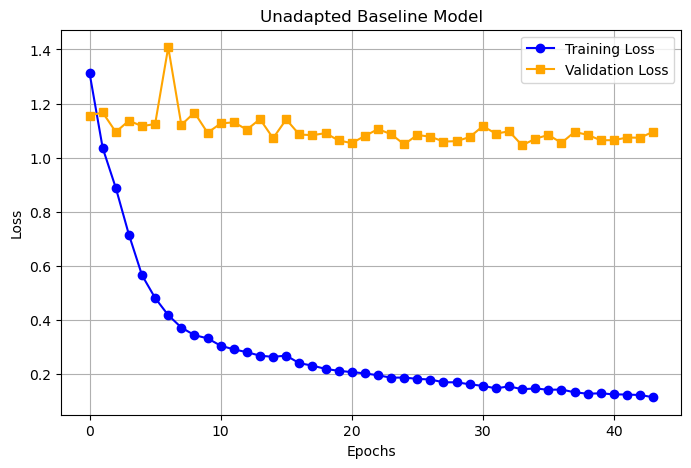

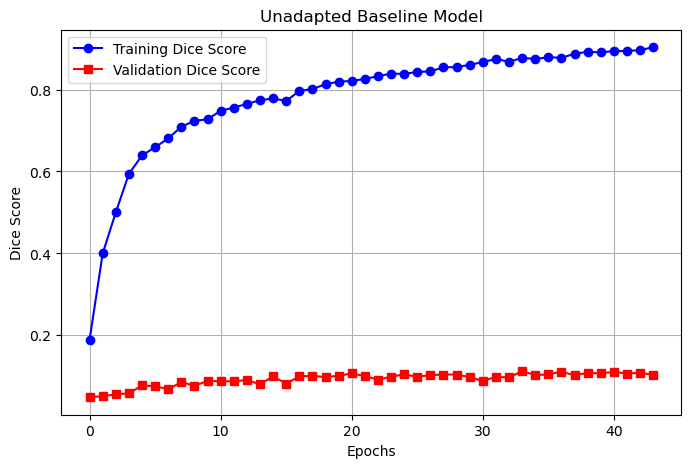

In [20]:
plotGraphs("Unadapted Baseline Model").plot_losses(training_losses, validation_losses)
plotGraphs("Unadapted Baseline Model").plot_metrics(train_dice_scores, valid_dice_scores)

In [19]:
def evaluate(model, test_loader, device, threshold, supervised=False):
	model.eval()
	preds, labels = [], []

	with torch.no_grad():
		if supervised:
			for img, label, _ in test_loader:
				img = img.to(device, dtype=torch.float32)
				label = label.to(device, dtype=torch.float32)

				segmentation_output, _ = model(img) 
				output = torch.sigmoid(segmentation_output) 

				preds.append(output.cpu())
				labels.append(label.cpu())
		else:
			for img, label in test_loader:
				img = img.to(device, dtype=torch.float32)
				label = label.to(device, dtype=torch.float32)
				
				segmentation_output, _ = model(img) 
				output = torch.sigmoid(segmentation_output) 

				preds.append(output.cpu())
				labels.append(label.cpu())

	preds = torch.cat(preds, dim=0)         
	labels = torch.cat(labels, dim=0)       
	binary_preds = (preds >= threshold).float()
	return binary_preds, labels

In [57]:
best_dice = 0
dice_scores_model1 = []
lesion_acc_scores_model1 = []
best_lesion_acc = 0
best_threshold = 0.7
model1_eval = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=2, classes=1)
model1_eval.to(DEVICE)
model1_eval.load_state_dict(torch.load("unet_baseline_model.pth"))
model1_eval.eval()
with torch.no_grad():
        for images, masks in val_loader:
            images = images.to('cuda', dtype=torch.float32)
            masks = masks.to('cuda', dtype=torch.float32)
            
            outputs = model1_eval(images) 
            preds = (torch.sigmoid(outputs) > best_threshold).float()
            
    
            masks_np = masks.squeeze(1).cpu().numpy()  # Remove channel dimension
            preds_np = preds.squeeze(1).cpu().numpy()  # Remove channel dimension
            
            for i in range(masks_np.shape[0]):
                dice_scores_model1.append(dice_score(masks_np[i], preds_np[i]))
                lesion_acc_scores_model1.append(lesion_wise_accuracy(masks_np[i], preds_np[i]))
        

print(f"Best dice score: {np.mean(np.array(dice_scores_model1)):.4f}")
print(f"Best f1 score: {np.mean(np.array(dice_scores_model1)):.4f}")
print(f"Best lesion-wise accuracy: {np.mean(np.array(lesion_acc_scores_model1)):.4f}")

Best dice score: 0.3084
Best f1 score: 0.3084
Best lesion-wise accuracy: 0.3157


In [58]:
dice_scores_model1 = np.array(dice_scores_model1)
lesion_acc_scores_model1 = np.array(lesion_acc_scores_model1)
print(f"Dice scores for model 1 shape {dice_scores_model1.shape}")
print(f"Lesion-wise accuracy scores for model 1 shape {lesion_acc_scores_model1.shape}")

Dice scores for model 1 shape (407,)
Lesion-wise accuracy scores for model 1 shape (407,)


In [26]:
torch.save(model1.state_dict(), "unet_baseline_model.pth")

In [39]:
class plotSamples:
	def __init__(self, model, val_loader, device, threshold, supervised=False):
		self.model = model
		self.val_loader = val_loader
		self.device = device
		self.threshold = threshold
		self.supervised = supervised

	def get_items(self):
		if self.supervised:
			val_images = self.val_loader.dataset.tensors[0].numpy()  # Images
			test_masks = self.val_loader.dataset.tensors[1].numpy()  # Ground truth masks
		else:
			val_images = self.val_loader.dataset.tensors[0].numpy()
			test_masks = self.val_loader.dataset.tensors[1].numpy()
		
		outputs, labels = evaluate(self.model, self.val_loader, device=self.device, threshold=self.threshold, supervised=self.supervised)
		outputs = outputs.squeeze(1).numpy()
		labels = labels.squeeze(1).numpy()
		
		dice_scores = [dice_score(labels[i], outputs[i]) for i in range(len(labels))]
		sorted_indices = np.argsort(dice_scores)
		
		best_dice_scores = [(dice_scores[i], i) for i in sorted_indices if dice_scores[i] != 1.0]
		worst_dice_scores = [(dice_scores[i], i) for i in sorted_indices]
		
		if len(best_dice_scores) >= 2:
			best_indices = [idx for score, idx in best_dice_scores[-2:]]
		else:
			best_indices = [idx for score, idx in sorted_indices[-2:]]
		
		worst_indices = [idx for score, idx in worst_dice_scores[:2]]
		
		two_best_masks_ground_truth = test_masks[best_indices]
		two_worst_masks_ground_truth = test_masks[worst_indices]
		two_best_masks_predictions = outputs[best_indices]
		two_worst_masks_predictions = outputs[worst_indices]
		
		return two_best_masks_ground_truth, two_best_masks_predictions, two_worst_masks_ground_truth, two_worst_masks_predictions
	
	def plot_samples(self):
		best_masks_gt, best_masks_pred, worst_masks_gt, worst_masks_pred = self.get_items()
		
		for i in range(min(2, len(best_masks_gt))):
			plt.figure(figsize=(10, 5))
			plt.subplot(1, 2, 1)
			# Handle different tensor dimensions
			if len(best_masks_gt[i].shape) == 3:
				plt.imshow(best_masks_gt[i][0], cmap='gray')
			else:
				plt.imshow(best_masks_gt[i], cmap='gray')
			plt.title(f'Best Mask Ground Truth {i+1}')
			plt.axis('off')
			
			plt.subplot(1, 2, 2)
			plt.imshow(best_masks_pred[i], cmap='gray')
			plt.title(f'Best Mask Prediction {i+1}')
			plt.axis('off')
			plt.show()
		
		for i in range(min(2, len(worst_masks_gt))):
			plt.figure(figsize=(10, 5))
			plt.subplot(1, 2, 1)
			if len(worst_masks_gt[i].shape) == 3:
				plt.imshow(worst_masks_gt[i][0], cmap='gray')
			else:
				plt.imshow(worst_masks_gt[i], cmap='gray')
			plt.title(f'Worst Mask Ground Truth {i+1}')
			plt.axis('off')
			
			plt.subplot(1, 2, 2)
			plt.imshow(worst_masks_pred[i], cmap='gray')
			plt.title(f'Worst Mask Prediction {i+1}')
			plt.axis('off') 
			plt.show()

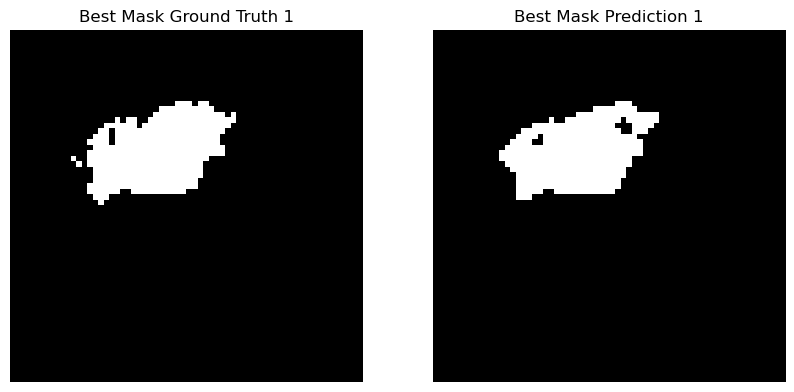

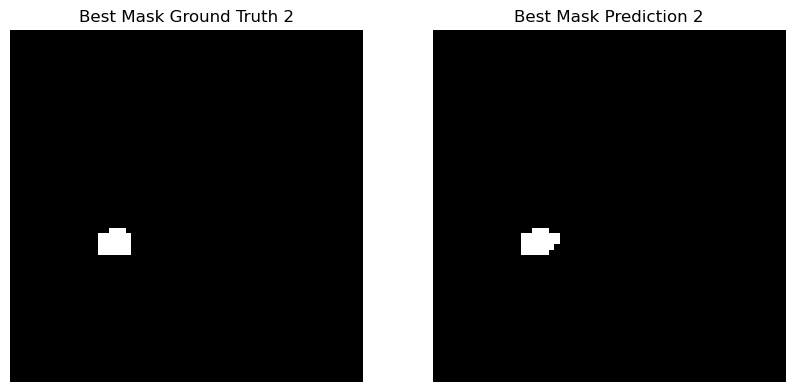

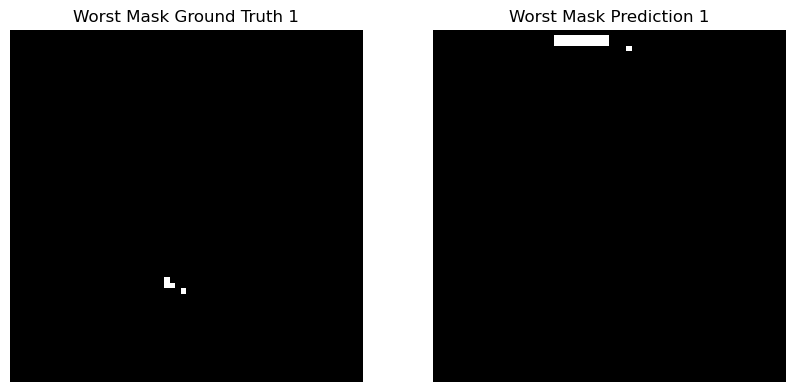

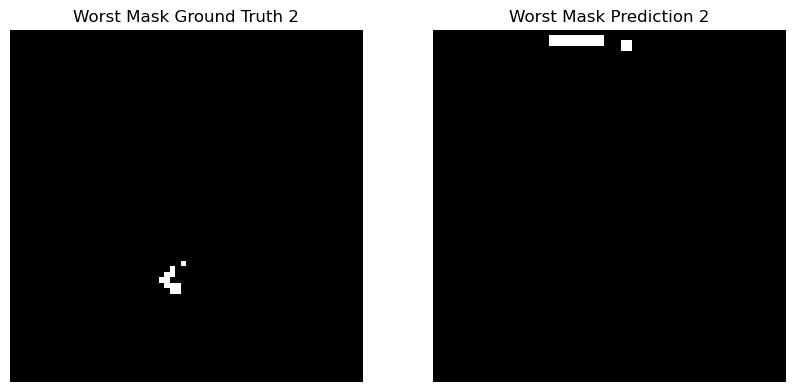

In [ ]:
plotSamples(model1, val_loader, device='cuda', threshold=0.5).plot_samples()

### b

In [41]:
combined_train_images = torch.cat((X_tensor, ds3_train), dim=0)
combined_train_masks = torch.cat((y_tensor, ds3_train_masks), dim=0)
ds2_domain_labels = torch.zeros(X_tensor.shape[0], 1) # Domain 0
ds3_domain_labels = torch.ones(ds3_train.shape[0], 1) # Domain 1
combined_domain_labels = torch.cat((ds2_domain_labels, ds3_domain_labels), dim=0)
supervised_da_train_dataset = TensorDataset(combined_train_images, combined_train_masks, combined_domain_labels)
supervised_da_train_loader = DataLoader(supervised_da_train_dataset, batch_size=32, shuffle=True)
ds3_test_domain_labels = torch.ones(ds3_test.shape[0], 1) # Domain 1 for target set
supervised_da_val_dataset = TensorDataset(ds3_test, ds3_test_masks, ds3_test_domain_labels)
supervised_da_val_loader = DataLoader(supervised_da_val_dataset, batch_size=32, shuffle=False)

print(f"Combined training images shape: {combined_train_images.shape}")
print(f"Combined training masks shape: {combined_train_masks.shape}")
print(f"Supervised DA train loader size: {len(supervised_da_train_loader)}") #Number of batches in the training loader
print(f"Supervised DA validation loader size: {len(supervised_da_val_loader)}") #Number of batches in the validation loader

Combined training images shape: torch.Size([2454, 2, 64, 64])
Combined training masks shape: torch.Size([2454, 1, 64, 64])
Supervised DA train loader size: 77
Supervised DA validation loader size: 13


In [34]:
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

In [35]:
class DomainAdaptationModel(nn.Module):
    def __init__(self, segmentation_model, grl_lambda=1.0):
        super(DomainAdaptationModel, self).__init__()
        self.segmentation_model = segmentation_model
        self.grl_lambda = grl_lambda

        self.domain_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        encoder_features = self.segmentation_model.encoder(x)[-1]
        segmentation_output = self.segmentation_model(x)

        reversed_features = GradientReversalLayer.apply(encoder_features, self.grl_lambda)
        domain_output = self.domain_classifier(reversed_features)

        return segmentation_output, domain_output


In [36]:
def supervised_da_trainer(model, train_loader, val_loader, segmentation_criterion,
                          domain_criterion, optimizer, num_epochs, device,
                          patience_counter, domain_loss_weight=0.1, scheduler=None):

    training_losses = []
    validation_losses = []
    train_dice_scores = []
    valid_dice_scores = []

    best_val_loss = float('inf')
    patience = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_seg_loss, epoch_domain_loss, epoch_total_loss = 0, 0, 0
        epoch_dice = 0
        num_train_samples = 0

        for images, masks, domain_labels in tqdm.tqdm(train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)
            domain_labels = domain_labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()

            segmentation_output, domain_output = model(images) # Get both segmentation and domain outputs(logits)

            seg_loss = segmentation_criterion(segmentation_output, masks)
            d_loss  = domain_criterion(domain_output, domain_labels)

            total_loss = seg_loss + domain_loss_weight * d_loss
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Add to epoch totals
            epoch_seg_loss += seg_loss.item() * images.size(0)
            epoch_domain_loss += d_loss.item() * images.size(0)
            epoch_total_loss += total_loss.item() * images.size(0) #images.size(0) is the batch size
            num_train_samples += images.size(0) # Add number of samples in the batch

            preds = (torch.sigmoid(segmentation_output) > 0.5).float()
            epoch_dice += dice_score(masks.cpu().numpy(), preds.cpu().numpy())

        # Epoch averages
        epoch_seg_loss /= num_train_samples
        epoch_domain_loss /= num_train_samples
        epoch_total_loss /= num_train_samples
        epoch_dice /= len(train_loader)

        training_losses.append(epoch_total_loss)
        train_dice_scores.append(epoch_dice)

        # Validation 
        model.eval()
        val_seg_loss = 0
        val_dice = 0
        num_val_samples = 0

        with torch.no_grad():
            for images, masks, _ in tqdm.tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)

                segmentation_output, _ = model(images) # Ignore domain output during validation

                seg_loss = segmentation_criterion(segmentation_output, masks)
                val_seg_loss += seg_loss.item() * images.size(0)

                preds = (torch.sigmoid(segmentation_output) > 0.5).float()
                val_dice += dice_score(masks.cpu().numpy(), preds.cpu().numpy())

                num_val_samples += images.size(0)

        val_seg_loss /= num_val_samples
        validation_losses.append(val_seg_loss)
        val_dice /= len(val_loader)
        valid_dice_scores.append(val_dice)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_total_loss:.4f} | Seg: {epoch_seg_loss:.4f} | Domain: {epoch_domain_loss:.4f}")
        print(f"Val Seg Loss: {val_seg_loss:.4f}")
        print(f"Train Dice: {epoch_dice:.4f} | Val Dice: {val_dice:.4f}\n")

        # Early stopping
        if val_seg_loss < best_val_loss:
            best_val_loss = val_seg_loss
            patience = 0
        else:
            patience += 1
            if patience >= patience_counter:
                print("Early stopping triggered.")
                break

        if scheduler:
            scheduler.step(val_seg_loss)

    return training_losses, validation_losses, train_dice_scores, valid_dice_scores


In [50]:
segmentation_criterion = criterion #Segmentation loss. Using combined loss
domain_criterion = nn.BCEWithLogitsLoss() #Domain loss. Requires logits as input.
model = smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",in_channels=2,classes=1)
domain_adaptation_model = DomainAdaptationModel(model, grl_lambda=0.1)
domain_adaptation_model.to(DEVICE)
optimizer_da = torch.optim.Adam(domain_adaptation_model.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler_da = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_da, mode='min', factor=0.5, patience=3)

In [51]:
supervised_da_training_losses, supervised_da_validation_losses, supervised_da_train_dice_scores, supervised_da_valid_dice_scores = supervised_da_trainer(
                                                        domain_adaptation_model,
                                                        supervised_da_train_loader,
                                                        supervised_da_val_loader,
                                                        segmentation_criterion,
                                                        domain_criterion,
                                                        optimizer_da,
                                                        num_epochs=50, 
                                                        device=DEVICE,
                                                        patience_counter=10,
                                                        domain_loss_weight=0.5, 
                                                        scheduler=scheduler_da)

Validation Epoch 1/50: 100%|██████████| 13/13 [00:00<00:00, 90.00it/s] 



Epoch 1/50
Train Loss: 1.9011 | Seg: 1.4210 | Domain: 0.9602
Val Seg Loss: 1.3243
Train Dice: 0.0470 | Val Dice: 0.0207



Validation Epoch 2/50: 100%|██████████| 13/13 [00:00<00:00, 109.50it/s]



Epoch 2/50
Train Loss: 1.7145 | Seg: 1.2442 | Domain: 0.9407
Val Seg Loss: 1.2369
Train Dice: 0.1645 | Val Dice: 0.0266



Validation Epoch 3/50: 100%|██████████| 13/13 [00:00<00:00, 107.82it/s]



Epoch 3/50
Train Loss: 1.6527 | Seg: 1.1594 | Domain: 0.9867
Val Seg Loss: 1.1681
Train Dice: 0.2973 | Val Dice: 0.0689



Validation Epoch 4/50: 100%|██████████| 13/13 [00:00<00:00, 107.67it/s]



Epoch 4/50
Train Loss: 1.5318 | Seg: 1.1024 | Domain: 0.8587
Val Seg Loss: 1.1940
Train Dice: 0.3433 | Val Dice: 0.0939



Validation Epoch 5/50: 100%|██████████| 13/13 [00:00<00:00, 108.28it/s]



Epoch 5/50
Train Loss: 1.4987 | Seg: 1.0373 | Domain: 0.9229
Val Seg Loss: 1.2309
Train Dice: 0.4352 | Val Dice: 0.1013



Validation Epoch 6/50: 100%|██████████| 13/13 [00:00<00:00, 109.38it/s]



Epoch 6/50
Train Loss: 1.3778 | Seg: 0.9881 | Domain: 0.7794
Val Seg Loss: 1.0768
Train Dice: 0.4845 | Val Dice: 0.1721



Validation Epoch 7/50: 100%|██████████| 13/13 [00:00<00:00, 108.07it/s]



Epoch 7/50
Train Loss: 1.4058 | Seg: 0.9358 | Domain: 0.9401
Val Seg Loss: 1.0373
Train Dice: 0.5284 | Val Dice: 0.1614



Validation Epoch 8/50: 100%|██████████| 13/13 [00:00<00:00, 109.79it/s]



Epoch 8/50
Train Loss: 1.2968 | Seg: 0.8818 | Domain: 0.8300
Val Seg Loss: 1.0362
Train Dice: 0.5572 | Val Dice: 0.1810



Validation Epoch 9/50: 100%|██████████| 13/13 [00:00<00:00, 109.73it/s]



Epoch 9/50
Train Loss: 1.2016 | Seg: 0.8303 | Domain: 0.7426
Val Seg Loss: 0.9325
Train Dice: 0.5927 | Val Dice: 0.3518



Validation Epoch 10/50: 100%|██████████| 13/13 [00:00<00:00, 110.28it/s]



Epoch 10/50
Train Loss: 1.1556 | Seg: 0.7653 | Domain: 0.7805
Val Seg Loss: 0.8506
Train Dice: 0.6337 | Val Dice: 0.4861



Validation Epoch 11/50: 100%|██████████| 13/13 [00:00<00:00, 108.45it/s]



Epoch 11/50
Train Loss: 1.0536 | Seg: 0.7040 | Domain: 0.6992
Val Seg Loss: 0.8167
Train Dice: 0.6650 | Val Dice: 0.4479



Validation Epoch 12/50: 100%|██████████| 13/13 [00:00<00:00, 108.25it/s]



Epoch 12/50
Train Loss: 1.0099 | Seg: 0.6375 | Domain: 0.7448
Val Seg Loss: 0.7665
Train Dice: 0.7003 | Val Dice: 0.4989



Validation Epoch 13/50: 100%|██████████| 13/13 [00:00<00:00, 109.53it/s]



Epoch 13/50
Train Loss: 0.9444 | Seg: 0.5712 | Domain: 0.7463
Val Seg Loss: 0.7126
Train Dice: 0.7236 | Val Dice: 0.5525



Validation Epoch 14/50: 100%|██████████| 13/13 [00:00<00:00, 108.49it/s]



Epoch 14/50
Train Loss: 0.8849 | Seg: 0.5299 | Domain: 0.7098
Val Seg Loss: 0.6867
Train Dice: 0.7277 | Val Dice: 0.5350



Validation Epoch 15/50: 100%|██████████| 13/13 [00:00<00:00, 109.16it/s]



Epoch 15/50
Train Loss: 0.8321 | Seg: 0.4763 | Domain: 0.7117
Val Seg Loss: 0.6411
Train Dice: 0.7482 | Val Dice: 0.5576



Validation Epoch 16/50: 100%|██████████| 13/13 [00:00<00:00, 108.97it/s]



Epoch 16/50
Train Loss: 0.8026 | Seg: 0.4435 | Domain: 0.7181
Val Seg Loss: 0.6113
Train Dice: 0.7532 | Val Dice: 0.5739



Validation Epoch 17/50: 100%|██████████| 13/13 [00:00<00:00, 109.18it/s]



Epoch 17/50
Train Loss: 0.7655 | Seg: 0.4089 | Domain: 0.7132
Val Seg Loss: 0.6222
Train Dice: 0.7651 | Val Dice: 0.5320



Validation Epoch 18/50: 100%|██████████| 13/13 [00:00<00:00, 107.49it/s]



Epoch 18/50
Train Loss: 0.7229 | Seg: 0.3827 | Domain: 0.6804
Val Seg Loss: 0.5632
Train Dice: 0.7691 | Val Dice: 0.5874



Validation Epoch 19/50: 100%|██████████| 13/13 [00:00<00:00, 107.68it/s]



Epoch 19/50
Train Loss: 0.7000 | Seg: 0.3466 | Domain: 0.7069
Val Seg Loss: 0.5328
Train Dice: 0.7880 | Val Dice: 0.6032



Validation Epoch 20/50: 100%|██████████| 13/13 [00:00<00:00, 108.23it/s]



Epoch 20/50
Train Loss: 0.6789 | Seg: 0.3210 | Domain: 0.7159
Val Seg Loss: 0.5186
Train Dice: 0.7976 | Val Dice: 0.6129



Validation Epoch 21/50: 100%|██████████| 13/13 [00:00<00:00, 107.13it/s]



Epoch 21/50
Train Loss: 0.6566 | Seg: 0.3074 | Domain: 0.6984
Val Seg Loss: 0.5859
Train Dice: 0.8024 | Val Dice: 0.5294



Validation Epoch 22/50: 100%|██████████| 13/13 [00:00<00:00, 106.87it/s]



Epoch 22/50
Train Loss: 0.6482 | Seg: 0.2941 | Domain: 0.7081
Val Seg Loss: 0.5228
Train Dice: 0.8038 | Val Dice: 0.5870



Validation Epoch 23/50: 100%|██████████| 13/13 [00:00<00:00, 108.59it/s]



Epoch 23/50
Train Loss: 0.6353 | Seg: 0.2783 | Domain: 0.7140
Val Seg Loss: 0.5268
Train Dice: 0.8105 | Val Dice: 0.5748



Validation Epoch 24/50: 100%|██████████| 13/13 [00:00<00:00, 108.26it/s]



Epoch 24/50
Train Loss: 0.6225 | Seg: 0.2662 | Domain: 0.7126
Val Seg Loss: 0.5121
Train Dice: 0.8156 | Val Dice: 0.5837



Validation Epoch 25/50: 100%|██████████| 13/13 [00:00<00:00, 110.33it/s]



Epoch 25/50
Train Loss: 0.6137 | Seg: 0.2638 | Domain: 0.6997
Val Seg Loss: 0.4869
Train Dice: 0.8126 | Val Dice: 0.6058



Validation Epoch 26/50: 100%|██████████| 13/13 [00:00<00:00, 109.43it/s]



Epoch 26/50
Train Loss: 0.5986 | Seg: 0.2532 | Domain: 0.6907
Val Seg Loss: 0.7272
Train Dice: 0.8181 | Val Dice: 0.3815



Validation Epoch 27/50: 100%|██████████| 13/13 [00:00<00:00, 109.88it/s]



Epoch 27/50
Train Loss: 0.6109 | Seg: 0.2436 | Domain: 0.7345
Val Seg Loss: 0.8830
Train Dice: 0.8229 | Val Dice: 0.3309



Validation Epoch 28/50: 100%|██████████| 13/13 [00:00<00:00, 106.75it/s]



Epoch 28/50
Train Loss: 0.5826 | Seg: 0.2292 | Domain: 0.7068
Val Seg Loss: 1.0195
Train Dice: 0.8324 | Val Dice: 0.2721



Validation Epoch 29/50: 100%|██████████| 13/13 [00:00<00:00, 108.92it/s]



Epoch 29/50
Train Loss: 0.5796 | Seg: 0.2284 | Domain: 0.7023
Val Seg Loss: 0.8334
Train Dice: 0.8308 | Val Dice: 0.3258



Validation Epoch 30/50: 100%|██████████| 13/13 [00:00<00:00, 109.63it/s]



Epoch 30/50
Train Loss: 0.5550 | Seg: 0.2165 | Domain: 0.6771
Val Seg Loss: 0.5069
Train Dice: 0.8392 | Val Dice: 0.5762



Validation Epoch 31/50: 100%|██████████| 13/13 [00:00<00:00, 109.34it/s]



Epoch 31/50
Train Loss: 0.5542 | Seg: 0.2112 | Domain: 0.6861
Val Seg Loss: 0.8046
Train Dice: 0.8437 | Val Dice: 0.3227



Validation Epoch 32/50: 100%|██████████| 13/13 [00:00<00:00, 109.30it/s]



Epoch 32/50
Train Loss: 0.5605 | Seg: 0.2056 | Domain: 0.7098
Val Seg Loss: 3.2014
Train Dice: 0.8473 | Val Dice: 0.1534



Validation Epoch 33/50: 100%|██████████| 13/13 [00:00<00:00, 109.35it/s]



Epoch 33/50
Train Loss: 0.5532 | Seg: 0.1985 | Domain: 0.7094
Val Seg Loss: 0.8598
Train Dice: 0.8524 | Val Dice: 0.3187



Validation Epoch 34/50: 100%|██████████| 13/13 [00:00<00:00, 108.28it/s]



Epoch 34/50
Train Loss: 0.5443 | Seg: 0.1938 | Domain: 0.7010
Val Seg Loss: 0.5903
Train Dice: 0.8565 | Val Dice: 0.4939



Validation Epoch 35/50: 100%|██████████| 13/13 [00:00<00:00, 109.27it/s]


Epoch 35/50
Train Loss: 0.5451 | Seg: 0.1947 | Domain: 0.7008
Val Seg Loss: 0.7758
Train Dice: 0.8561 | Val Dice: 0.3686

Early stopping triggered.


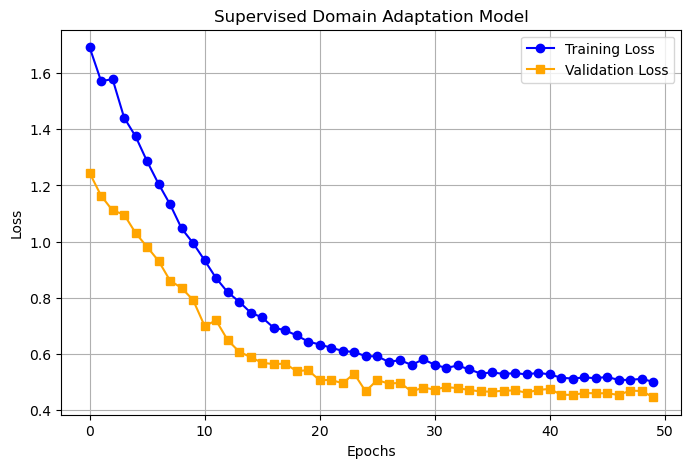

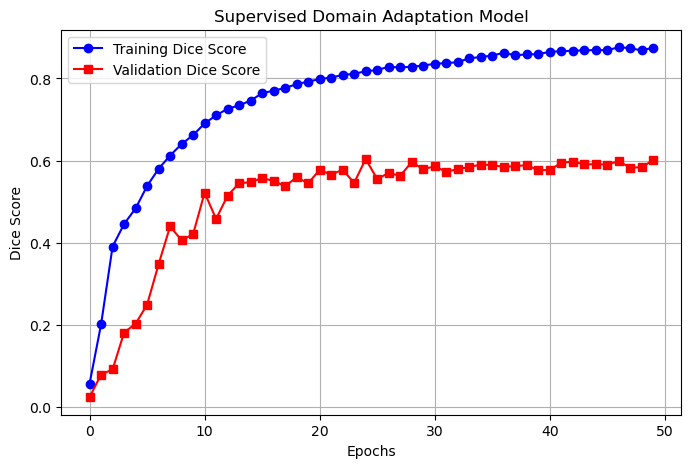

In [29]:
plotGraphs("Supervised Domain Adaptation Model").plot_losses(supervised_da_training_losses, supervised_da_validation_losses)
plotGraphs("Supervised Domain Adaptation Model").plot_metrics(supervised_da_train_dice_scores, supervised_da_valid_dice_scores)

In [52]:
domain_adaptation_model.eval()

total_val_loss = 0.0
total_dice_score = 0.0
dice_scores_model2 = []
lesion_acc_scores_model2 = []
total_lesion_accuracy = 0.0
num_samples = 0

with torch.no_grad():
    for images, masks, domain_labels in tqdm.tqdm(supervised_da_val_loader, desc="Evaluating Supervised DA Model"):
        images, masks, domain_labels = images.to(DEVICE), masks.to(DEVICE), domain_labels.to(DEVICE)

        segmentation_output, _ = domain_adaptation_model(images)

        loss = segmentation_criterion(segmentation_output, masks)
        total_val_loss += loss.item() * images.size(0)
        num_samples += images.size(0)

        preds = (torch.sigmoid(segmentation_output) > 0.5).float()

        masks_np = masks.cpu().numpy()
        preds_np = preds.cpu().numpy()

        for i in range(masks_np.shape[0]):
            total_dice_score += dice_score(masks_np[i, 0], preds_np[i, 0])
            dice_scores_model2.append(dice_score(masks_np[i, 0], preds_np[i, 0]))
        for i in range(masks_np.shape[0]):
             total_lesion_accuracy += lesion_wise_accuracy(masks_np[i, 0], preds_np[i, 0])
             lesion_acc_scores_model2.append(lesion_wise_accuracy(masks_np[i, 0], preds_np[i, 0]))


average_dice_score = total_dice_score / num_samples
average_lesion_accuracy = total_lesion_accuracy / num_samples

print("\n" + "="*50)
print(f"Supervised Domain Adaptation Model Performance on Dataset 3 Test Set:")
print(f"Best Validation Dice Score: {max(supervised_da_valid_dice_scores):.4f}")
print(f"Best f1-score: {max(supervised_da_valid_dice_scores):.4f}")
print(f"Average Lesion-wise Accuracy (F1): {average_lesion_accuracy:.4f}")
print("="*50)

Evaluating Supervised DA Model: 100%|██████████| 13/13 [00:00<00:00, 68.81it/s]


Supervised Domain Adaptation Model Performance on Dataset 3 Test Set:
Best Validation Dice Score: 0.6129
Best f1-score: 0.6129
Average Lesion-wise Accuracy (F1): 0.4356


In [55]:
dice_scores_model2 = np.array(dice_scores_model2)
lesion_acc_scores_model2 = np.array(lesion_acc_scores_model2)
print(f"Dice scores for model 2 shape {dice_scores_model2.shape}")
print(f"Lesion-wise accuracy scores for model 2 shape {lesion_acc_scores_model2.shape}")

Dice scores for model 2: shape (407,)
Lesion-wise accuracy scores for model 2 shape (407,)


In [53]:
torch.save(domain_adaptation_model.state_dict(), "supervised_da_unet_model.pth")

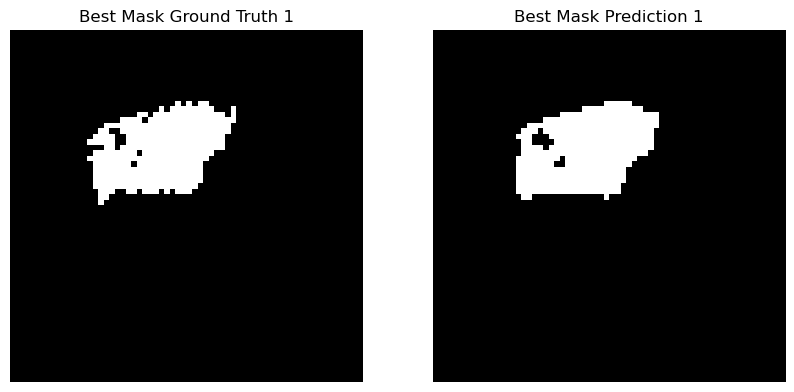

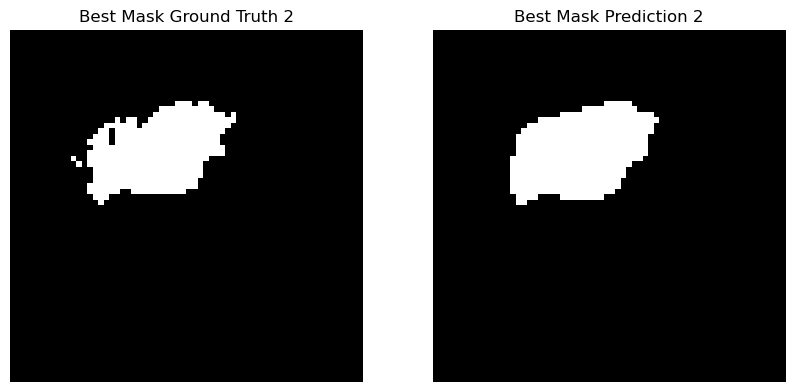

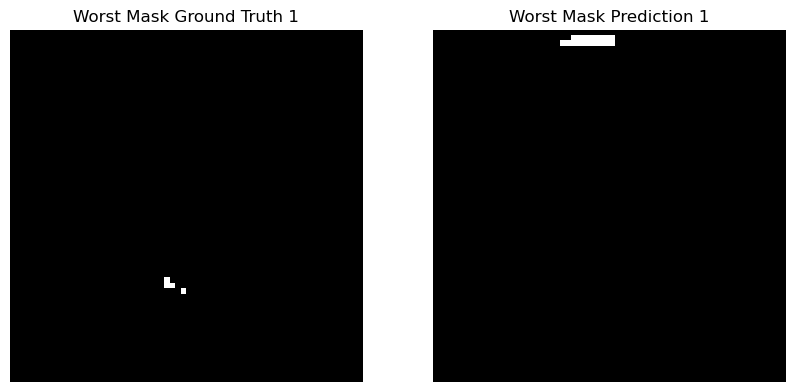

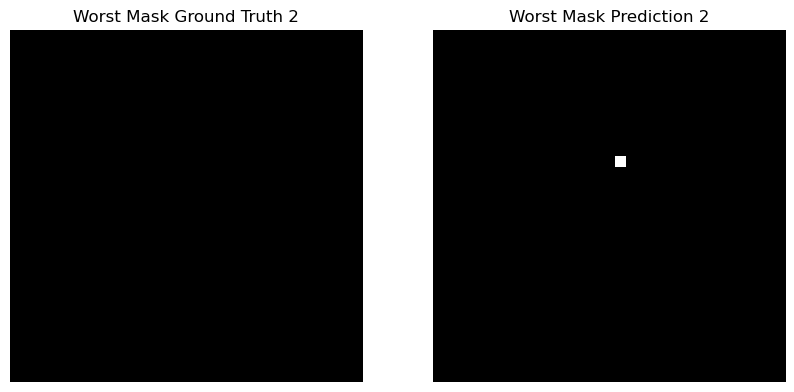

In [ ]:
plotSamples(domain_adaptation_model, supervised_da_val_loader, device='cuda', threshold=0.5, supervised=True).plot_samples()

### Unsepervised Domain Adaptation

In [59]:
def uda_trainer(model, source_loader, target_loader, val_loader, segmentation_criterion, 
                     domain_criterion, optimizer, device, num_epochs, domain_loss_weight=0.01, 
                     grl_schedule=True, grl_max=0.1, scheduler=None):
    
    best_val_loss = float("inf")
    patience = 0
    patience_counter = 15  # Increased patience for UDA

    model.to(device)
    training_logs = {
        'train_seg_loss': [], 'train_domain_loss': [], 'train_total_loss': [], 
        'train_dice': [], 'val_seg_loss': [], 'val_dice': []
    }

    len_src = len(source_loader)
    len_tgt = len(target_loader)
    max_steps_per_epoch = max(len_src, len_tgt)

    global_step = 0
    total_steps = num_epochs * max_steps_per_epoch

    for epoch in range(num_epochs):
        model.train()
        epoch_seg_loss = 0.0
        epoch_domain_loss = 0.0
        epoch_total_loss = 0.0
        epoch_dice = 0.0
        epoch_samples = 0

        src_iter = iter(source_loader)
        tgt_iter = iter(target_loader)

        for step in tqdm.tqdm(range(max_steps_per_epoch), desc=f"Epoch {epoch+1}/{num_epochs}"):
            # Get source batch
            try:
                src_batch = next(src_iter)
            except StopIteration:
                src_iter = iter(source_loader)
                src_batch = next(src_iter)

            # Get target batch
            try:
                tgt_batch = next(tgt_iter)
            except StopIteration:
                tgt_iter = iter(target_loader)
                tgt_batch = next(tgt_iter)

            # Extract data
            src_images, src_masks = src_batch[0], src_batch[1]
            tgt_images = tgt_batch[0] if isinstance(tgt_batch, (list, tuple)) else tgt_batch

            # Move to device
            src_images = src_images.to(device, dtype=torch.float32)
            src_masks = src_masks.to(device, dtype=torch.float32)
            tgt_images = tgt_images.to(device, dtype=torch.float32)

            batch_size_src = src_images.size(0)
            batch_size_tgt = tgt_images.size(0)

            if grl_schedule:
                p = float(global_step) / float(total_steps)
                grl_lambda = grl_max * (2.0 / (1.0 + np.exp(-10.0 * p)) - 1.0) * 0.1
            else:
                grl_lambda = grl_max
            
            model.grl_lambda = grl_lambda

            optimizer.zero_grad()

            # Forward pass
            src_seg_logits, src_domain_logits = model(src_images)
            _, tgt_domain_logits = model(tgt_images)

            # Segmentation loss (only on source)
            seg_loss = segmentation_criterion(src_seg_logits, src_masks)

            # Domain loss
            domain_logits = torch.cat([src_domain_logits, tgt_domain_logits], dim=0)
            domain_labels_src = torch.zeros(batch_size_src, 1, device=device, dtype=torch.float32)
            domain_labels_tgt = torch.ones(batch_size_tgt, 1, device=device, dtype=torch.float32)
            domain_labels = torch.cat([domain_labels_src, domain_labels_tgt], dim=0)

            domain_loss = domain_criterion(domain_logits, domain_labels)

            # Total loss with adaptive weight
            adaptive_weight = min(domain_loss_weight * (epoch + 1) / 10, domain_loss_weight)
            total_loss = seg_loss + adaptive_weight * domain_loss

            # Backward pass
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_seg_loss += seg_loss.item() * batch_size_src
            epoch_domain_loss += domain_loss.item() * (batch_size_src + batch_size_tgt)
            epoch_total_loss += total_loss.item() * batch_size_src
            epoch_samples += batch_size_src

            with torch.no_grad():
                seg_probs = torch.sigmoid(src_seg_logits)
                seg_preds = (seg_probs > 0.5).float()
                
                if seg_preds.dim() == 4 and seg_preds.shape[1] == 1:
                    seg_preds_np = seg_preds.squeeze(1).cpu().numpy()
                    src_masks_np = src_masks.squeeze(1).cpu().numpy()
                else:
                    seg_preds_np = seg_preds.cpu().numpy()
                    src_masks_np = src_masks.cpu().numpy()
                
                batch_dice = dice_score(src_masks_np, seg_preds_np)
                epoch_dice += batch_dice

            global_step += 1

        # Calculate epoch averages
        epoch_seg_loss = epoch_seg_loss / epoch_samples
        epoch_domain_loss = epoch_domain_loss / (max_steps_per_epoch * (batch_size_src + batch_size_tgt))
        epoch_total_loss = epoch_total_loss / epoch_samples
        epoch_dice_mean = epoch_dice / max_steps_per_epoch

        training_logs['train_seg_loss'].append(epoch_seg_loss)
        training_logs['train_domain_loss'].append(epoch_domain_loss)
        training_logs['train_total_loss'].append(epoch_total_loss)
        training_logs['train_dice'].append(epoch_dice_mean)

        # Validation
        model.eval()
        val_seg_loss_acc = 0.0
        val_samples = 0
        val_dice_acc = 0.0
        
        with torch.no_grad():
            for v_images, v_masks, _ in val_loader:
                v_images = v_images.to(device, dtype=torch.float32)
                v_masks = v_masks.to(device, dtype=torch.float32)

                v_seg_logits, _ = model(v_images)
                v_seg_loss = segmentation_criterion(v_seg_logits, v_masks)
                val_seg_loss_acc += v_seg_loss.item() * v_images.size(0)
                val_samples += v_images.size(0)

                v_probs = torch.sigmoid(v_seg_logits)
                v_preds = (v_probs > 0.5).float()
                
                if v_preds.dim() == 4 and v_preds.shape[1] == 1:
                    v_preds_np = v_preds.squeeze(1).cpu().numpy()
                    v_masks_np = v_masks.squeeze(1).cpu().numpy()
                else:
                    v_preds_np = v_preds.cpu().numpy()
                    v_masks_np = v_masks.cpu().numpy()
                
                val_dice_batch = dice_score(v_masks_np, v_preds_np)
                val_dice_acc += val_dice_batch

        val_seg_loss = val_seg_loss_acc / val_samples
        val_dice = val_dice_acc / len(val_loader)

        training_logs['val_seg_loss'].append(val_seg_loss)
        training_logs['val_dice'].append(val_dice)

        # Early stopping
        if val_seg_loss < best_val_loss:
            best_val_loss = val_seg_loss
            patience = 0
        else:
            patience += 1
            if patience >= patience_counter:
                print("Early stopping triggered.")
                break

        # Learning rate scheduling
        if scheduler:
            scheduler.step(val_seg_loss)

        print("="*60)
        print(f"Train Seg Loss: {epoch_seg_loss:.4f}, Domain Loss: {epoch_domain_loss:.4f}")
        print(f"Total Loss: {epoch_total_loss:.4f}")
        print(f"Train Dice: {epoch_dice_mean:.4f} | Val Dice: {val_dice:.4f}")
        print(f"Val Seg Loss: {val_seg_loss:.4f}")
        print("="*60)

    return training_logs

In [ ]:
model3 = smp.Unet(encoder_name="resnet34",encoder_weights="imagenet",in_channels=2,classes=1)
model3.to(DEVICE)
uda_model = DomainAdaptationModel(model3, grl_lambda=0.1)
uda_model.to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
seg_crit = criterion
domain_crit = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.AdamW(uda_model.parameters(), lr=1e-4, weight_decay=1e-5)

In [38]:
target_images_only = TensorDataset(ds3_train)
target_loader = DataLoader(target_images_only, batch_size=32, shuffle=True)

In [40]:
logs = uda_trainer(uda_model, supervised_da_train_loader, target_loader, supervised_da_val_loader,
                    seg_crit, domain_crit, optimizer, DEVICE, num_epochs=50, 
                    domain_loss_weight=0.01, grl_schedule=True, grl_max=0.1, scheduler=scheduler)

Epoch 1/50: 100%|██████████| 77/77 [00:04<00:00, 17.69it/s]


Train Seg Loss: 1.1001, Domain Loss: 0.5943
Total Loss: 1.1006
Train Dice: 0.4443 | Val Dice: 0.1964
Val Seg Loss: 1.1009


Epoch 2/50: 100%|██████████| 77/77 [00:04<00:00, 17.70it/s]


Train Seg Loss: 1.0049, Domain Loss: 0.5120
Total Loss: 1.0058
Train Dice: 0.4982 | Val Dice: 0.2992
Val Seg Loss: 1.0410


Epoch 3/50: 100%|██████████| 77/77 [00:04<00:00, 17.76it/s]


Train Seg Loss: 0.9014, Domain Loss: 0.4604
Total Loss: 0.9025
Train Dice: 0.5810 | Val Dice: 0.4358
Val Seg Loss: 0.9359


Epoch 4/50: 100%|██████████| 77/77 [00:04<00:00, 17.68it/s]


Train Seg Loss: 0.7965, Domain Loss: 0.3908
Total Loss: 0.7979
Train Dice: 0.6356 | Val Dice: 0.4058
Val Seg Loss: 0.8749


Epoch 5/50: 100%|██████████| 77/77 [00:04<00:00, 18.43it/s]


Train Seg Loss: 0.6950, Domain Loss: 0.4089
Total Loss: 0.6967
Train Dice: 0.6703 | Val Dice: 0.5228
Val Seg Loss: 0.7723


Epoch 6/50: 100%|██████████| 77/77 [00:04<00:00, 18.38it/s]


Train Seg Loss: 0.6015, Domain Loss: 0.4419
Total Loss: 0.6038
Train Dice: 0.6959 | Val Dice: 0.5185
Val Seg Loss: 0.7316


Epoch 7/50: 100%|██████████| 77/77 [00:04<00:00, 17.52it/s]


Train Seg Loss: 0.5185, Domain Loss: 0.5035
Total Loss: 0.5215
Train Dice: 0.7261 | Val Dice: 0.4667
Val Seg Loss: 0.7070


Epoch 8/50: 100%|██████████| 77/77 [00:04<00:00, 17.62it/s]


Train Seg Loss: 0.4486, Domain Loss: 0.3890
Total Loss: 0.4512
Train Dice: 0.7410 | Val Dice: 0.5682
Val Seg Loss: 0.6042


Epoch 9/50: 100%|██████████| 77/77 [00:04<00:00, 17.51it/s]


Train Seg Loss: 0.3973, Domain Loss: 0.3745
Total Loss: 0.4002
Train Dice: 0.7551 | Val Dice: 0.5308
Val Seg Loss: 0.6027


Epoch 10/50: 100%|██████████| 77/77 [00:04<00:00, 18.60it/s]


Train Seg Loss: 0.3477, Domain Loss: 0.3463
Total Loss: 0.3506
Train Dice: 0.7743 | Val Dice: 0.5432
Val Seg Loss: 0.5778


Epoch 11/50: 100%|██████████| 77/77 [00:04<00:00, 18.67it/s]


Train Seg Loss: 0.3253, Domain Loss: 0.3364
Total Loss: 0.3281
Train Dice: 0.7787 | Val Dice: 0.5626
Val Seg Loss: 0.5437


Epoch 12/50: 100%|██████████| 77/77 [00:04<00:00, 18.88it/s]


Train Seg Loss: 0.2965, Domain Loss: 0.3061
Total Loss: 0.2991
Train Dice: 0.7909 | Val Dice: 0.5386
Val Seg Loss: 0.5550


Epoch 13/50: 100%|██████████| 77/77 [00:04<00:00, 18.29it/s]


Train Seg Loss: 0.2677, Domain Loss: 0.2813
Total Loss: 0.2701
Train Dice: 0.8074 | Val Dice: 0.5519
Val Seg Loss: 0.5341


Epoch 14/50: 100%|██████████| 77/77 [00:04<00:00, 17.63it/s]


Train Seg Loss: 0.2559, Domain Loss: 0.2807
Total Loss: 0.2583
Train Dice: 0.8116 | Val Dice: 0.5564
Val Seg Loss: 0.5243


Epoch 15/50: 100%|██████████| 77/77 [00:04<00:00, 17.29it/s]


Train Seg Loss: 0.2474, Domain Loss: 0.2307
Total Loss: 0.2493
Train Dice: 0.8130 | Val Dice: 0.5666
Val Seg Loss: 0.5082


Epoch 16/50: 100%|██████████| 77/77 [00:04<00:00, 17.03it/s]


Train Seg Loss: 0.2307, Domain Loss: 0.2427
Total Loss: 0.2328
Train Dice: 0.8242 | Val Dice: 0.5657
Val Seg Loss: 0.5050


Epoch 17/50: 100%|██████████| 77/77 [00:04<00:00, 17.43it/s]


Train Seg Loss: 0.2201, Domain Loss: 0.2383
Total Loss: 0.2221
Train Dice: 0.8295 | Val Dice: 0.5535
Val Seg Loss: 0.5118


Epoch 18/50: 100%|██████████| 77/77 [00:04<00:00, 17.40it/s]


Train Seg Loss: 0.2149, Domain Loss: 0.2464
Total Loss: 0.2170
Train Dice: 0.8313 | Val Dice: 0.5690
Val Seg Loss: 0.5027


Epoch 19/50: 100%|██████████| 77/77 [00:04<00:00, 16.98it/s]


Train Seg Loss: 0.2082, Domain Loss: 0.2141
Total Loss: 0.2100
Train Dice: 0.8355 | Val Dice: 0.6126
Val Seg Loss: 0.4510


Epoch 20/50: 100%|██████████| 77/77 [00:04<00:00, 17.53it/s]


Train Seg Loss: 0.2027, Domain Loss: 0.2409
Total Loss: 0.2048
Train Dice: 0.8387 | Val Dice: 0.6000
Val Seg Loss: 0.4601


Epoch 21/50: 100%|██████████| 77/77 [00:04<00:00, 17.72it/s]


Train Seg Loss: 0.2014, Domain Loss: 0.2457
Total Loss: 0.2035
Train Dice: 0.8384 | Val Dice: 0.5904
Val Seg Loss: 0.4712


Epoch 22/50: 100%|██████████| 77/77 [00:04<00:00, 17.65it/s]


Train Seg Loss: 0.1887, Domain Loss: 0.2271
Total Loss: 0.1906
Train Dice: 0.8491 | Val Dice: 0.5768
Val Seg Loss: 0.4848


Epoch 23/50: 100%|██████████| 77/77 [00:04<00:00, 17.99it/s]


Train Seg Loss: 0.1810, Domain Loss: 0.2124
Total Loss: 0.1828
Train Dice: 0.8552 | Val Dice: 0.5883
Val Seg Loss: 0.4686


Epoch 24/50: 100%|██████████| 77/77 [00:04<00:00, 18.46it/s]


Train Seg Loss: 0.1802, Domain Loss: 0.2402
Total Loss: 0.1822
Train Dice: 0.8553 | Val Dice: 0.5869
Val Seg Loss: 0.4687


Epoch 25/50: 100%|██████████| 77/77 [00:04<00:00, 17.84it/s]


Train Seg Loss: 0.1747, Domain Loss: 0.2068
Total Loss: 0.1765
Train Dice: 0.8589 | Val Dice: 0.5596
Val Seg Loss: 0.4991


Epoch 26/50: 100%|██████████| 77/77 [00:04<00:00, 17.57it/s]


Train Seg Loss: 0.1746, Domain Loss: 0.2322
Total Loss: 0.1766
Train Dice: 0.8581 | Val Dice: 0.5891
Val Seg Loss: 0.4643


Epoch 27/50: 100%|██████████| 77/77 [00:04<00:00, 17.21it/s]


Train Seg Loss: 0.1683, Domain Loss: 0.1944
Total Loss: 0.1699
Train Dice: 0.8635 | Val Dice: 0.6063
Val Seg Loss: 0.4458


Epoch 28/50: 100%|██████████| 77/77 [00:04<00:00, 17.48it/s]


Train Seg Loss: 0.1693, Domain Loss: 0.2136
Total Loss: 0.1711
Train Dice: 0.8618 | Val Dice: 0.5762
Val Seg Loss: 0.4753


Epoch 29/50: 100%|██████████| 77/77 [00:04<00:00, 17.86it/s]


Train Seg Loss: 0.1647, Domain Loss: 0.2291
Total Loss: 0.1666
Train Dice: 0.8652 | Val Dice: 0.5816
Val Seg Loss: 0.4687


Epoch 30/50: 100%|██████████| 77/77 [00:04<00:00, 17.97it/s]


Train Seg Loss: 0.1623, Domain Loss: 0.2283
Total Loss: 0.1643
Train Dice: 0.8671 | Val Dice: 0.6117
Val Seg Loss: 0.4354


Epoch 31/50: 100%|██████████| 77/77 [00:04<00:00, 18.12it/s]


Train Seg Loss: 0.1569, Domain Loss: 0.2620
Total Loss: 0.1591
Train Dice: 0.8716 | Val Dice: 0.5853
Val Seg Loss: 0.4666


Epoch 32/50: 100%|██████████| 77/77 [00:04<00:00, 18.07it/s]


Train Seg Loss: 0.1550, Domain Loss: 0.2286
Total Loss: 0.1569
Train Dice: 0.8732 | Val Dice: 0.5870
Val Seg Loss: 0.4660


Epoch 33/50: 100%|██████████| 77/77 [00:04<00:00, 17.48it/s]


Train Seg Loss: 0.1500, Domain Loss: 0.2267
Total Loss: 0.1519
Train Dice: 0.8775 | Val Dice: 0.5719
Val Seg Loss: 0.4829


Epoch 34/50: 100%|██████████| 77/77 [00:04<00:00, 17.50it/s]


Train Seg Loss: 0.1456, Domain Loss: 0.2109
Total Loss: 0.1474
Train Dice: 0.8811 | Val Dice: 0.6147
Val Seg Loss: 0.4362


Epoch 35/50: 100%|██████████| 77/77 [00:04<00:00, 17.61it/s]


Train Seg Loss: 0.1489, Domain Loss: 0.2586
Total Loss: 0.1511
Train Dice: 0.8784 | Val Dice: 0.5431
Val Seg Loss: 0.5160


Epoch 36/50: 100%|██████████| 77/77 [00:04<00:00, 17.49it/s]


Train Seg Loss: 0.1479, Domain Loss: 0.2482
Total Loss: 0.1500
Train Dice: 0.8788 | Val Dice: 0.5811
Val Seg Loss: 0.4727


Epoch 37/50: 100%|██████████| 77/77 [00:04<00:00, 17.57it/s]


Train Seg Loss: 0.1607, Domain Loss: 0.2575
Total Loss: 0.1629
Train Dice: 0.8670 | Val Dice: 0.5558
Val Seg Loss: 0.5029


Epoch 38/50: 100%|██████████| 77/77 [00:04<00:00, 17.66it/s]


Train Seg Loss: 0.1439, Domain Loss: 0.2517
Total Loss: 0.1460
Train Dice: 0.8819 | Val Dice: 0.5166
Val Seg Loss: 0.5477


Epoch 39/50: 100%|██████████| 77/77 [00:04<00:00, 17.43it/s]


Train Seg Loss: 0.1429, Domain Loss: 0.2385
Total Loss: 0.1449
Train Dice: 0.8823 | Val Dice: 0.5330
Val Seg Loss: 0.5258


Epoch 40/50: 100%|██████████| 77/77 [00:04<00:00, 17.75it/s]


Train Seg Loss: 0.1414, Domain Loss: 0.2490
Total Loss: 0.1435
Train Dice: 0.8835 | Val Dice: 0.5877
Val Seg Loss: 0.4607


Epoch 41/50: 100%|██████████| 77/77 [00:04<00:00, 18.12it/s]


Train Seg Loss: 0.1285, Domain Loss: 0.2403
Total Loss: 0.1306
Train Dice: 0.8951 | Val Dice: 0.5684
Val Seg Loss: 0.4865


Epoch 42/50: 100%|██████████| 77/77 [00:04<00:00, 18.19it/s]


Train Seg Loss: 0.1321, Domain Loss: 0.2242
Total Loss: 0.1340
Train Dice: 0.8919 | Val Dice: 0.5845
Val Seg Loss: 0.4722


Epoch 43/50: 100%|██████████| 77/77 [00:04<00:00, 18.34it/s]


Train Seg Loss: 0.1302, Domain Loss: 0.2319
Total Loss: 0.1322
Train Dice: 0.8930 | Val Dice: 0.5605
Val Seg Loss: 0.4931


Epoch 44/50: 100%|██████████| 77/77 [00:04<00:00, 17.78it/s]


Train Seg Loss: 0.1288, Domain Loss: 0.2747
Total Loss: 0.1312
Train Dice: 0.8941 | Val Dice: 0.5481
Val Seg Loss: 0.5096


Epoch 45/50: 100%|██████████| 77/77 [00:04<00:00, 18.15it/s]


Early stopping triggered.


In [ ]:
torch.save(uda_model.state_dict(), 'uda_model.pth')

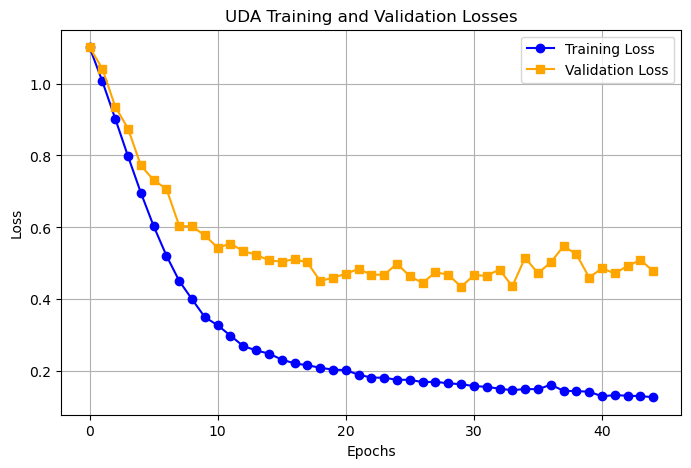

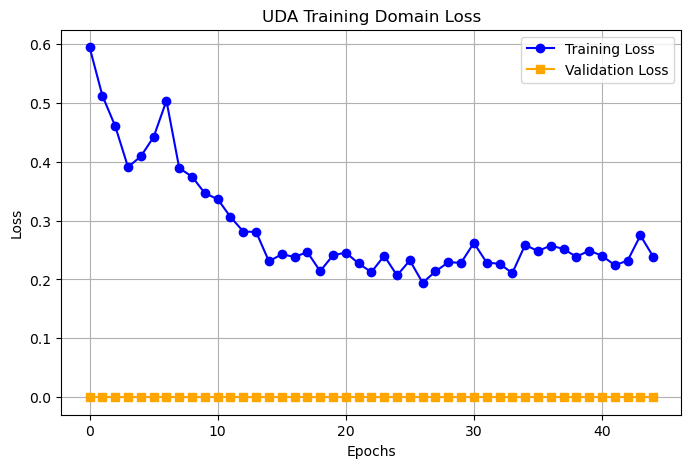

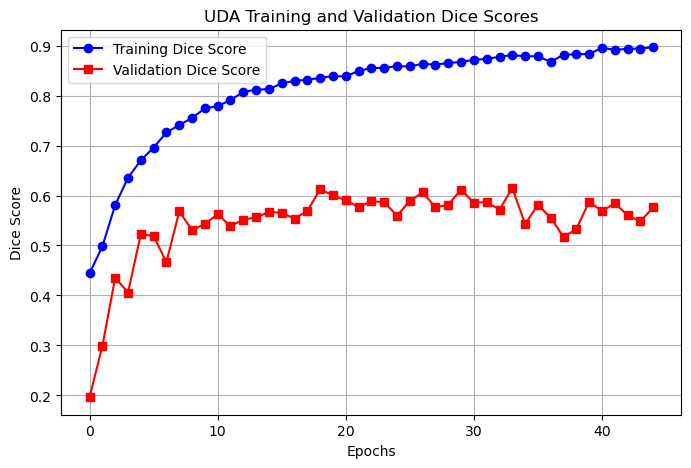

In [42]:
plotGraphs('UDA Training and Validation Losses').plot_losses(logs['train_total_loss'], logs['val_seg_loss'])
plotGraphs('UDA Training Domain Loss').plot_losses(logs['train_domain_loss'], [0]*len(logs['val_seg_loss']))
plotGraphs('UDA Training and Validation Dice Scores').plot_metrics(logs['train_dice'], logs['val_dice'])

In [61]:
# Evaluate the UDA model on the validation set
uda_model = DomainAdaptationModel(model, grl_lambda=0.1)
uda_model.to(DEVICE)
uda_model.load_state_dict(torch.load('uda_model.pth'))
uda_model.eval()
total_dice = 0
dice_scores_model3 = []
lesion_acc_scores_model3 = []
num_batches = 0
lwa = []
with torch.no_grad():
    for images, labels, _ in supervised_da_val_loader:  
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        seg_outputs, _ = uda_model(images)  
        
        seg_probs = torch.sigmoid(seg_outputs)
        seg_preds = (seg_probs > 0.5).float()
        
        labels_np = labels.squeeze(1).cpu().numpy() 
        seg_preds_np = seg_preds.squeeze(1).cpu().numpy() 
        
        batch_dice = 0
        batch_lesion_accuracy = 0
        batch_size = labels_np.shape[0]
        
        for i in range(batch_size):
            sample_dice = dice_score(labels_np[i], seg_preds_np[i])
            dice_scores_model3.append(sample_dice)
            sample_lesion_acc = lesion_wise_accuracy(labels_np[i], seg_preds_np[i])
            lesion_acc_scores_model3.append(sample_lesion_acc)
            batch_dice += sample_dice
            batch_lesion_accuracy += sample_lesion_acc
        
        batch_dice /= batch_size
        batch_lesion_accuracy /= batch_size
        
        total_dice += batch_dice
        num_batches += 1
        
        print(f"Batch {num_batches} Dice Score: {batch_dice:.4f}")
        lwa.append(round(batch_lesion_accuracy, 4))


avg_dice = total_dice / num_batches
print(f"Average Validation Dice Score: {avg_dice:.4f}")

Batch 1 Dice Score: 0.5408
Batch 2 Dice Score: 0.3696
Batch 3 Dice Score: 0.4634
Batch 4 Dice Score: 0.5593
Batch 5 Dice Score: 0.6236
Batch 6 Dice Score: 0.5332
Batch 7 Dice Score: 0.3446
Batch 8 Dice Score: 0.5392
Batch 9 Dice Score: 0.4377
Batch 10 Dice Score: 0.3109
Batch 11 Dice Score: 0.4997
Batch 12 Dice Score: 0.4708
Batch 13 Dice Score: 0.6939
Average Validation Dice Score: 0.4913


In [44]:
print(f"Best Validation Dice Score: {max(logs['val_dice']):.4f}")
print(f"Best validation lesion wise accuracy {max(lwa)}")

Best Validation Dice Score: 0.6147
Best validation lesion wise accuracy 0.5813


In [62]:
dice_scores_model3 = np.array(dice_scores_model3)
lesion_acc_scores_model3 = np.array(lesion_acc_scores_model3)
print(f"Dice scores for model 3 shape {dice_scores_model3.shape}")
print(f"Lesion-wise accuracy scores for model 3 shape {lesion_acc_scores_model3.shape}")

Dice scores for model 3 shape (407,)
Lesion-wise accuracy scores for model 3 shape (407,)


In [47]:
def get_items_uda(model, val_loader, device, threshold):
    val_images = val_loader.dataset.tensors[0].numpy()  # Images
    test_masks = val_loader.dataset.tensors[1].numpy()  # Ground truth masks
    
    outputs, labels = evaluate(model, val_loader, device=device, threshold=threshold, supervised=True)
    outputs = outputs.squeeze(1).numpy()
    labels = labels.squeeze(1).numpy()
    
    dice_scores = [dice_score(labels[i], outputs[i]) for i in range(len(labels))]
    sorted_indices = np.argsort(dice_scores)
    
    best_dice_scores = [(dice_scores[i], i) for i in sorted_indices if dice_scores[i] != 1.0]
    worst_dice_scores = [(dice_scores[i], i) for i in sorted_indices]
    
    if len(best_dice_scores) >= 2:
        best_indices = [idx for score, idx in best_dice_scores[-2:]]
    else:
        best_indices = [idx for score, idx in sorted_indices[-2:]]
    
    worst_indices = [idx for score, idx in worst_dice_scores[:2]]
    
    two_best_masks_ground_truth = test_masks[best_indices]
    two_worst_masks_ground_truth = test_masks[worst_indices]
    two_best_masks_predictions = outputs[best_indices]
    two_worst_masks_predictions = outputs[worst_indices]
    
    return two_best_masks_ground_truth, two_best_masks_predictions, two_worst_masks_ground_truth, two_worst_masks_predictions

In [48]:
two_best_gt, two_best_pred, two_worst_gt, two_worst_pred = get_items_uda(uda_model, supervised_da_val_loader, device='cuda', threshold=0.5)

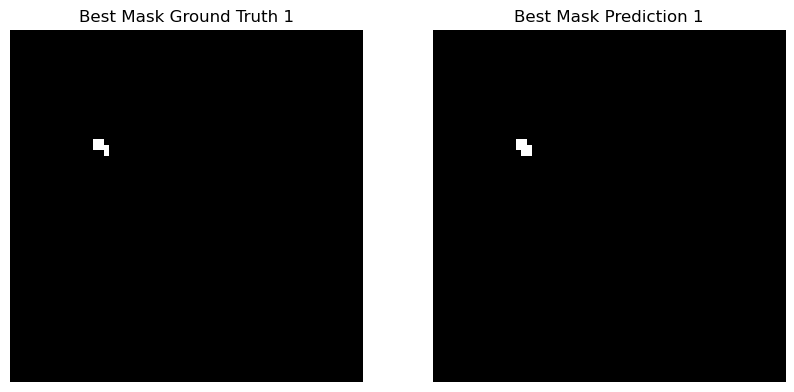

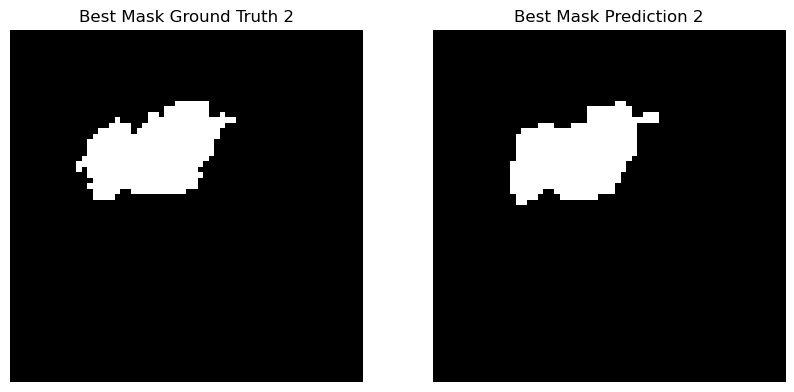

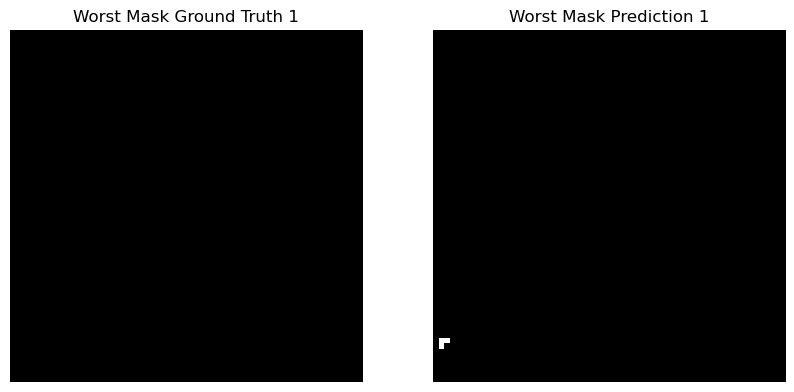

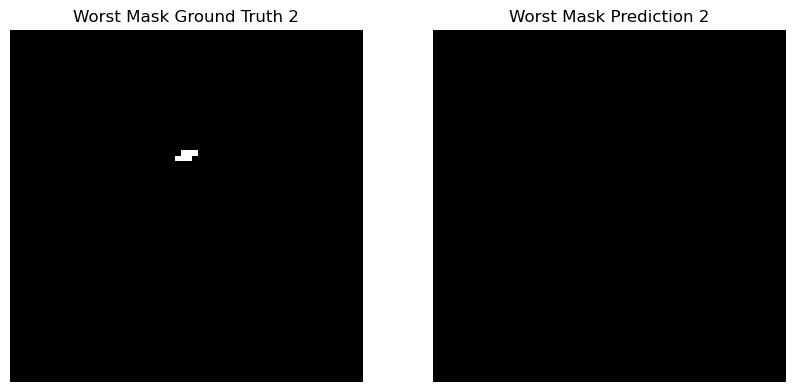

In [ ]:
#Plot best and worst samples for UDA model
for i in range(min(2, len(two_best_gt))):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    if len(two_best_gt[i].shape) == 3:
        plt.imshow(two_best_gt[i][0], cmap='gray')
    else:
        plt.imshow(two_best_gt[i], cmap='gray')
    plt.title(f'Best Mask Ground Truth {i+1}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(two_best_pred[i], cmap='gray')
    plt.title(f'Best Mask Prediction {i+1}')
    plt.axis('off')
    plt.show()
for i in range(min(2, len(two_worst_gt))):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    if len(two_worst_gt[i].shape) == 3:
        plt.imshow(two_worst_gt[i][0], cmap='gray')
    else:
        plt.imshow(two_worst_gt[i], cmap='gray')
    plt.title(f'Worst Mask Ground Truth {i+1}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(two_worst_pred[i], cmap='gray')
    plt.title(f'Worst Mask Prediction {i+1}')
    plt.axis('off') 
    plt.show()

#### Perform statistical testing for all performance metrics for dataset 3 for unsupervised and supervised domain adaptation with respect to the baseline un adapted model.

In [68]:
from scipy import stats
import pandas as pd

def perform_statistical_analysis(baseline_scores, supervised_scores, unsupervised_scores, metric_name):
    
    print(f"\n{'='*60}")
    print(f"STATISTICAL ANALYSIS FOR {metric_name.upper()}")
    print(f"{'='*60}")
    
    # Descriptive statistics
    print(f"\nDescriptive Statistics:")
    print(f"Baseline Model - Mean: {np.mean(baseline_scores):.4f}, Std: {np.std(baseline_scores):.4f}")
    print(f"Supervised DA - Mean: {np.mean(supervised_scores):.4f}, Std: {np.std(supervised_scores):.4f}")
    print(f"Unsupervised DA - Mean: {np.mean(unsupervised_scores):.4f}, Std: {np.std(unsupervised_scores):.4f}")
    
    # Paired t-test
    min_len = min(len(baseline_scores), len(supervised_scores), len(unsupervised_scores))
    baseline_subset = baseline_scores[:min_len]
    supervised_subset = supervised_scores[:min_len]
    unsupervised_subset = unsupervised_scores[:min_len]
    
    # Supervised vs Baseline
    t_stat_sup, p_val_sup = stats.ttest_rel(supervised_subset, baseline_subset)
    print(f"\nSupervised DA vs Baseline:")
    print(f"Paired t-test: t-statistic = {t_stat_sup:.4f}, p-value = {p_val_sup:.4f}")
    if p_val_sup < 0.05:
        print("Statistically significant difference (p < 0.05)")
    else:
        print("No statistically significant difference (p >= 0.05)")
    
    # Unsupervised vs Baseline
    t_stat_unsup, p_val_unsup = stats.ttest_rel(unsupervised_subset, baseline_subset)
    print(f"\nUnsupervised DA vs Baseline:")
    print(f"Paired t-test: t-statistic = {t_stat_unsup:.4f}, p-value = {p_val_unsup:.4f}")
    if p_val_unsup < 0.05:
        print("Statistically significant difference (p < 0.05)")
    else:
        print("No statistically significant difference (p >= 0.05)")
    
    # Wilcoxon signed-rank test 
    print(f"\nNon-parametric tests (Wilcoxon signed-rank):")
    
    # Supervised vs Baseline
    wilcox_stat_sup, wilcox_p_sup = stats.wilcoxon(supervised_subset, baseline_subset)
    print(f"Supervised DA vs Baseline: Wilcoxon statistic = {wilcox_stat_sup:.4f}, p-value = {wilcox_p_sup:.4f}")
    
    # Unsupervised vs Baseline
    wilcox_stat_unsup, wilcox_p_unsup = stats.wilcoxon(unsupervised_subset, baseline_subset)
    print(f"Unsupervised DA vs Baseline: Wilcoxon statistic = {wilcox_stat_unsup:.4f}, p-value = {wilcox_p_unsup:.4f}")
    
    # Effect size (Cohen's d)
    def cohens_d(x1, x2):
        pooled_std = np.sqrt(((len(x1) - 1) * np.var(x1, ddof=1) + (len(x2) - 1) * np.var(x2, ddof=1)) / (len(x1) + len(x2) - 2))
        return (np.mean(x1) - np.mean(x2)) / pooled_std
    
    cohens_d_sup = cohens_d(supervised_subset, baseline_subset)
    cohens_d_unsup = cohens_d(unsupervised_subset, baseline_subset)
    
    print(f"\nEffect Size (Cohen's d):")
    print(f"Supervised DA vs Baseline: {cohens_d_sup:.4f}")
    print(f"Unsupervised DA vs Baseline: {cohens_d_unsup:.4f}")
    
    return {
        'metric': metric_name,
        'baseline_mean': np.mean(baseline_scores),
        'supervised_mean': np.mean(supervised_scores),
        'unsupervised_mean': np.mean(unsupervised_scores),
        'sup_vs_base_pvalue': p_val_sup,
        'unsup_vs_base_pvalue': p_val_unsup,
        'sup_vs_base_cohens_d': cohens_d_sup,
        'unsup_vs_base_cohens_d': cohens_d_unsup
    }


# Dice Scores Analysis
dice_results = perform_statistical_analysis(
    dice_scores_model1, 
    dice_scores_model2, 
    dice_scores_model3, 
    "Dice Score"
)

# Lesion-wise Accuracy Analysis
lesion_results = perform_statistical_analysis(
    lesion_acc_scores_model1, 
    lesion_acc_scores_model2, 
    lesion_acc_scores_model3, 
    "Lesion-wise Accuracy"
)


STATISTICAL ANALYSIS FOR DICE SCORE

Descriptive Statistics:
Baseline Model - Mean: 0.3084, Std: 0.4229
Supervised DA - Mean: 0.4411, Std: 0.4226
Unsupervised DA - Mean: 0.4868, Std: 0.4126

Supervised DA vs Baseline:
Paired t-test: t-statistic = 6.2028, p-value = 0.0000
Statistically significant difference (p < 0.05)

Unsupervised DA vs Baseline:
Paired t-test: t-statistic = 9.1269, p-value = 0.0000
Statistically significant difference (p < 0.05)

Non-parametric tests (Wilcoxon signed-rank):
Supervised DA vs Baseline: Wilcoxon statistic = 5954.0000, p-value = 0.0000
Unsupervised DA vs Baseline: Wilcoxon statistic = 3381.0000, p-value = 0.0000

Effect Size (Cohen's d):
Supervised DA vs Baseline: 0.3135
Unsupervised DA vs Baseline: 0.4266

STATISTICAL ANALYSIS FOR LESION-WISE ACCURACY

Descriptive Statistics:
Baseline Model - Mean: 0.3157, Std: 0.4427
Supervised DA - Mean: 0.4356, Std: 0.4527
Unsupervised DA - Mean: 0.4651, Std: 0.4547

Supervised DA vs Baseline:
Paired t-test: t-stati


SUMMARY TABLE
                 metric  baseline_mean  supervised_mean  unsupervised_mean  \
0            Dice Score         0.3084           0.4411             0.4868   
1  Lesion-wise Accuracy         0.3157           0.4356             0.4651   

   sup_vs_base_pvalue  unsup_vs_base_pvalue  sup_vs_base_cohens_d  \
0                 0.0                   0.0                0.3135   
1                 0.0                   0.0                0.2674   

   unsup_vs_base_cohens_d  
0                  0.4266  
1                  0.3325  


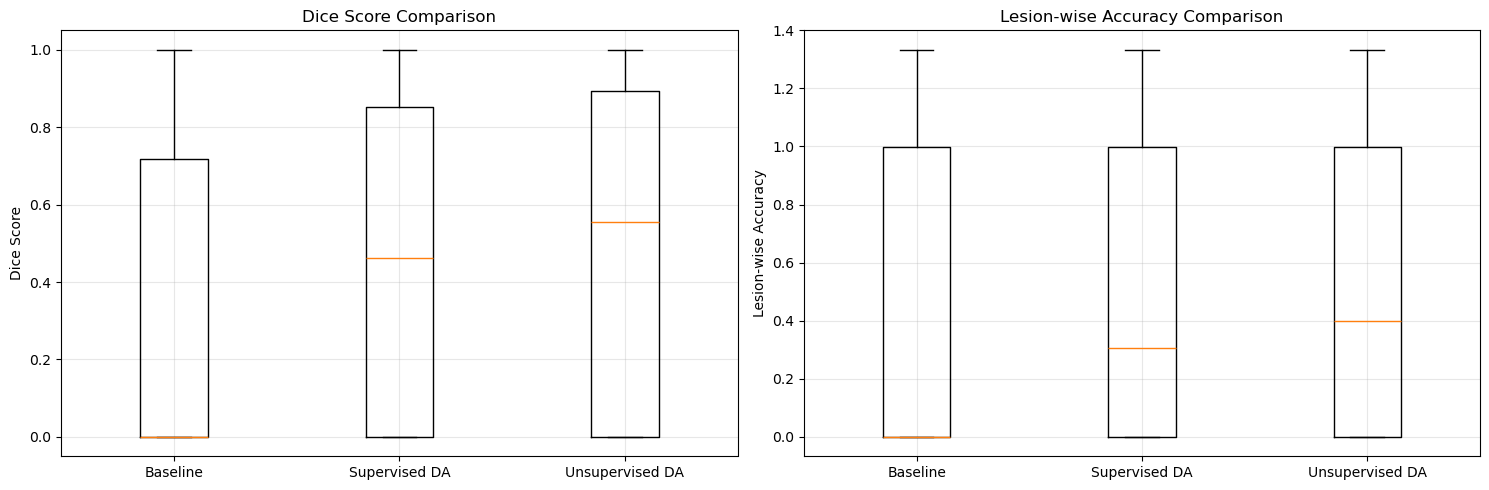

In [ ]:
summary_df = pd.DataFrame([dice_results, lesion_results])
print(f"\n{'='*60}")
print("SUMMARY TABLE")
print(f"{'='*60}")
print(summary_df.round(4))

plt.figure(figsize=(15, 5))

# Dice scores comparison
plt.subplot(1, 2, 1)
plt.boxplot([dice_scores_model1, dice_scores_model2, dice_scores_model3], tick_labels=['Baseline', 'Supervised DA', 'Unsupervised DA'])
plt.title('Dice Score Comparison')
plt.ylabel('Dice Score')
plt.grid(True, alpha=0.3)

# Lesion-wise accuracy comparison
plt.subplot(1, 2, 2)
plt.boxplot([lesion_acc_scores_model1, lesion_acc_scores_model2, lesion_acc_scores_model3], tick_labels=['Baseline', 'Supervised DA', 'Unsupervised DA'])
plt.title('Lesion-wise Accuracy Comparison')
plt.ylabel('Lesion-wise Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()